# Run detection/keypoints/densepose models on videos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt

from src.dataset.dataset import Dataset


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import cv2
import numpy as np
from tqdm.notebook import tqdm

In [3]:
dataset = Dataset(rootdir="../data/database_convertida/")

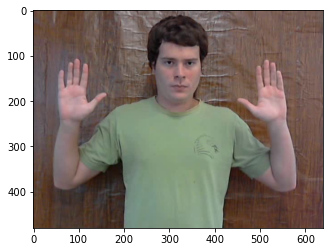

In [4]:
video = dataset[281]
frame = video.get_frame(40)
plt.imshow(frame[:,:,::-1])
plt.show()

## Instance segmentation

In [5]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

outputs = predictor(frame)

/nfs/home/wesley.passos/repos/libras/src/detectron2/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


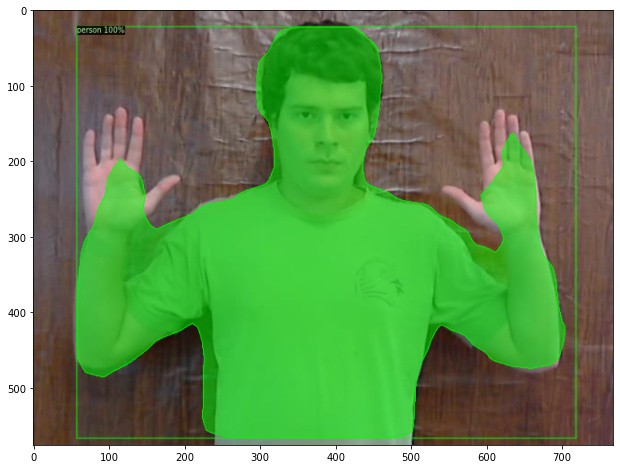

In [6]:
v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(12,8))
plt.imshow(out.get_image()[:, :,])
plt.show()

## keypoints

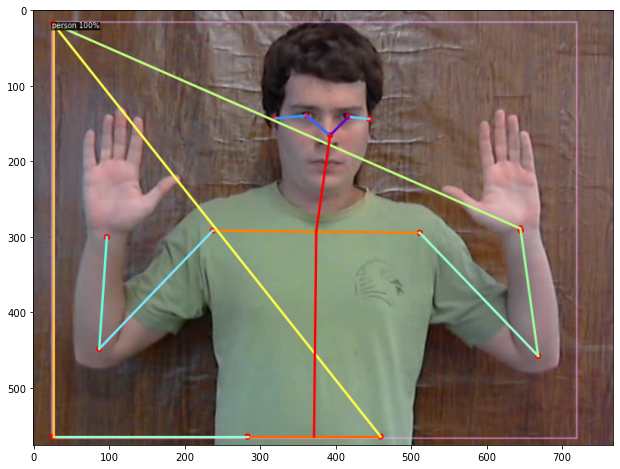

In [7]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(frame)

v = Visualizer(frame[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(12,8))
plt.imshow(out.get_image()[:, :,])
plt.show()

## Densepose

In [9]:
sys.path.append('../src/detectron2/projects/DensePose/')
from densepose import add_densepose_config, add_hrnet_config

from densepose.vis.base import CompoundVisualizer
from densepose.vis.bounding_box import ScoredBoundingBoxVisualizer
from densepose.vis.densepose import (
    DensePoseResultsContourVisualizer,
    DensePoseResultsFineSegmentationVisualizer,
    DensePoseResultsUVisualizer,
    DensePoseResultsVVisualizer,
)
from densepose.vis.extractor import CompoundExtractor, create_extractor


In [10]:
config_file = '../src/detectron2/projects/DensePose/configs/densepose_rcnn_R_50_FPN_s1x.yaml'
model_url = 'https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl'

In [11]:
VISUALIZERS = {
        "dp_contour": DensePoseResultsContourVisualizer,
        "dp_segm": DensePoseResultsFineSegmentationVisualizer,
        "dp_u": DensePoseResultsUVisualizer,
        "dp_v": DensePoseResultsVVisualizer,
        "bbox": ScoredBoundingBoxVisualizer,
    }

def create_context(vis_specs):        
        visualizers = []
        extractors = []
        for vis_spec in vis_specs:
            vis = VISUALIZERS[vis_spec]()
            visualizers.append(vis)
            extractor = create_extractor(vis)
            extractors.append(extractor)
        visualizer = CompoundVisualizer(visualizers)
        extractor = CompoundExtractor(extractors)
        context = {
            "extractor": extractor,
            "visualizer": visualizer,
#             "out_fname": args.output,
#             "entry_idx": 0,
        }
        return context

In [12]:
# Inference with a keypoint detection model
cfg = get_cfg()

add_densepose_config(cfg)
add_hrnet_config(cfg)    
cfg.merge_from_file(config_file)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_url

predictor = DefaultPredictor(cfg)
outputs = predictor(frame)

Config '../src/detectron2/projects/DensePose/configs/densepose_rcnn_R_50_FPN_s1x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


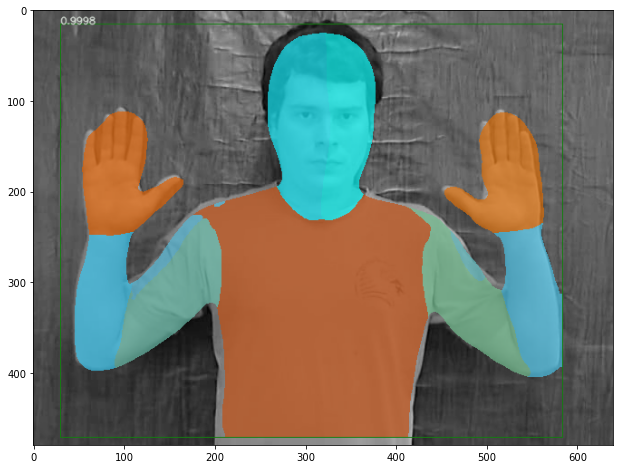

In [13]:
context = create_context(('bbox', 'dp_segm',))

visualizer = context["visualizer"]
extractor = context["extractor"]

image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
image = np.tile(image[:, :, np.newaxis], [1, 1, 3])
data = extractor(outputs['instances'])

plt.figure(figsize=(12,8))

image_vis = visualizer.visualize(image, data)
plt.imshow(image_vis)
plt.show()

In [14]:
# run for whole video and generate a video
video.reset()
size = (640,480) #(w,h)
out = cv2.VideoWriter('sample_segm.avi',cv2.VideoWriter_fourcc(*'MJPG'), 10, size)

for frame in video.frame_by_frame():   
    outputs = predictor(frame)    
    
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    image = np.tile(image[:, :, np.newaxis], [1, 1, 3])
    
    data = extractor(outputs['instances'])
    image_vis = visualizer.visualize(image, data)

    out.write(cv2.cvtColor(image_vis, cv2.COLOR_RGB2BGR))

    
out.release()

### get all body segmentation

In [15]:
import torch
from densepose.data.samplers import densepose_to_mask

In [16]:
seg = densepose_to_mask(outputs['instances'])

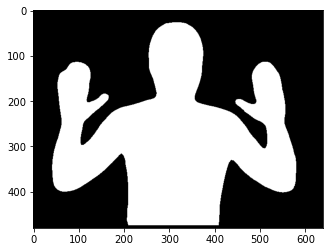

In [17]:
plt.imshow(seg.tensor.squeeze().type(torch.float32), cmap='gray')
plt.show()

### get body parts segmentation


In [18]:
import json
from densepose.data.structures import DensePoseResult

In [19]:
iuv_arr = DensePoseResult.decode_png_data(*(data[-1].results[0])) 
i = iuv_arr[0, :, :]
bbox = np.array(data[-1].boxes_xywh[0])

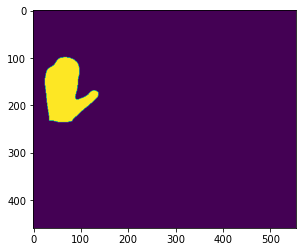

In [20]:
# 3 means right hand
# The details on which part corresponds to which index can be found here:
# https://github.com/facebookresearch/DensePose/blob/master/challenge/2019_COCO_DensePose/data_format.md
plt.imshow(i[:,:] == 3)
plt.show()

Let's run the model over all video and store bboxes and segmentations in a json file

In [21]:
def run_on_video(video, model):
    # run for whole video
    annotations = {}
    for frame_nb, frame in tqdm(enumerate(video.frame_by_frame()), total=(video.get_nb_frames()-1)):   
        annotations[f'frame_{frame_nb:03d}'] = dict()
        
        
        outputs = predictor(frame)    
        data = extractor(outputs['instances'])

        iuv_arr = DensePoseResult.decode_png_data(*(data[-1].results[0])) 
        i = iuv_arr[0, :, :].tolist()
        bbox = data[-1].boxes_xywh[0]
                
        annotations[f'frame_{frame_nb:03d}']['bbox'] = bbox
        annotations[f'frame_{frame_nb:03d}']['segm'] = i                
    
    return annotations    

In [22]:
def run_on_dataset(dataset, model):
    for video in tqdm(dataset, total=len(dataset)):        
        video_annotations = run_on_video(video, model)
        
        with open(video.filepath.replace('.avi', '.json'), 'w') as outfile:
            json.dump(video_annotations, outfile)    

In [ ]:
run_on_dataset(dataset, predictor)